# Section 5.3 — Bayesian difference between means

This notebook contains the code examples from [Section 5.3 Bayesian difference between means]() from the **No Bullshit Guide to Statistics**.

See also:
- [Half_a_dozen_dmeans_in_Bambi.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/Half_a_dozen_dmeans_in_Bambi.ipynb)
- [t-test.ipynb](./explorations/bambi/t-test.ipynb)
- Examples: https://github.com/treszkai/best/tree/master/examples
- Links: https://www.one-tab.com/page/HoSHco_iSG-MHXG7kXOj7g



#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bambi as bmb
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/dmeans"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Model

## Example 1: electricity prices

Electricity prices from East End and West End

### Data

In [26]:
eprices = pd.read_csv("../datasets/eprices.csv")
eprices.groupby("loc")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
loc,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


In [5]:
from ministats.bayes import bayes_dmeans

epricesW = eprices[eprices["loc"]=="West"]["price"]
epricesE = eprices[eprices["loc"]=="East"]["price"]
mod1, idata1 = bayes_dmeans(epricesW, epricesE, group_name="loc", var_name="price", groups=["West", "East"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, loc, sigma_loc]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [6]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata1, group_name="loc");
az.summary(idata1, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_West", "sigma_East", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,2.958,0.650,1.723,4.245
sigma_West,1.563,0.449,0.822,2.471
sigma_East,0.916,0.273,0.459,1.455
dstd,0.648,0.519,-0.375,1.671
nu,20.785,13.883,1.711,48.243
cohend,2.388,0.707,1.007,3.702


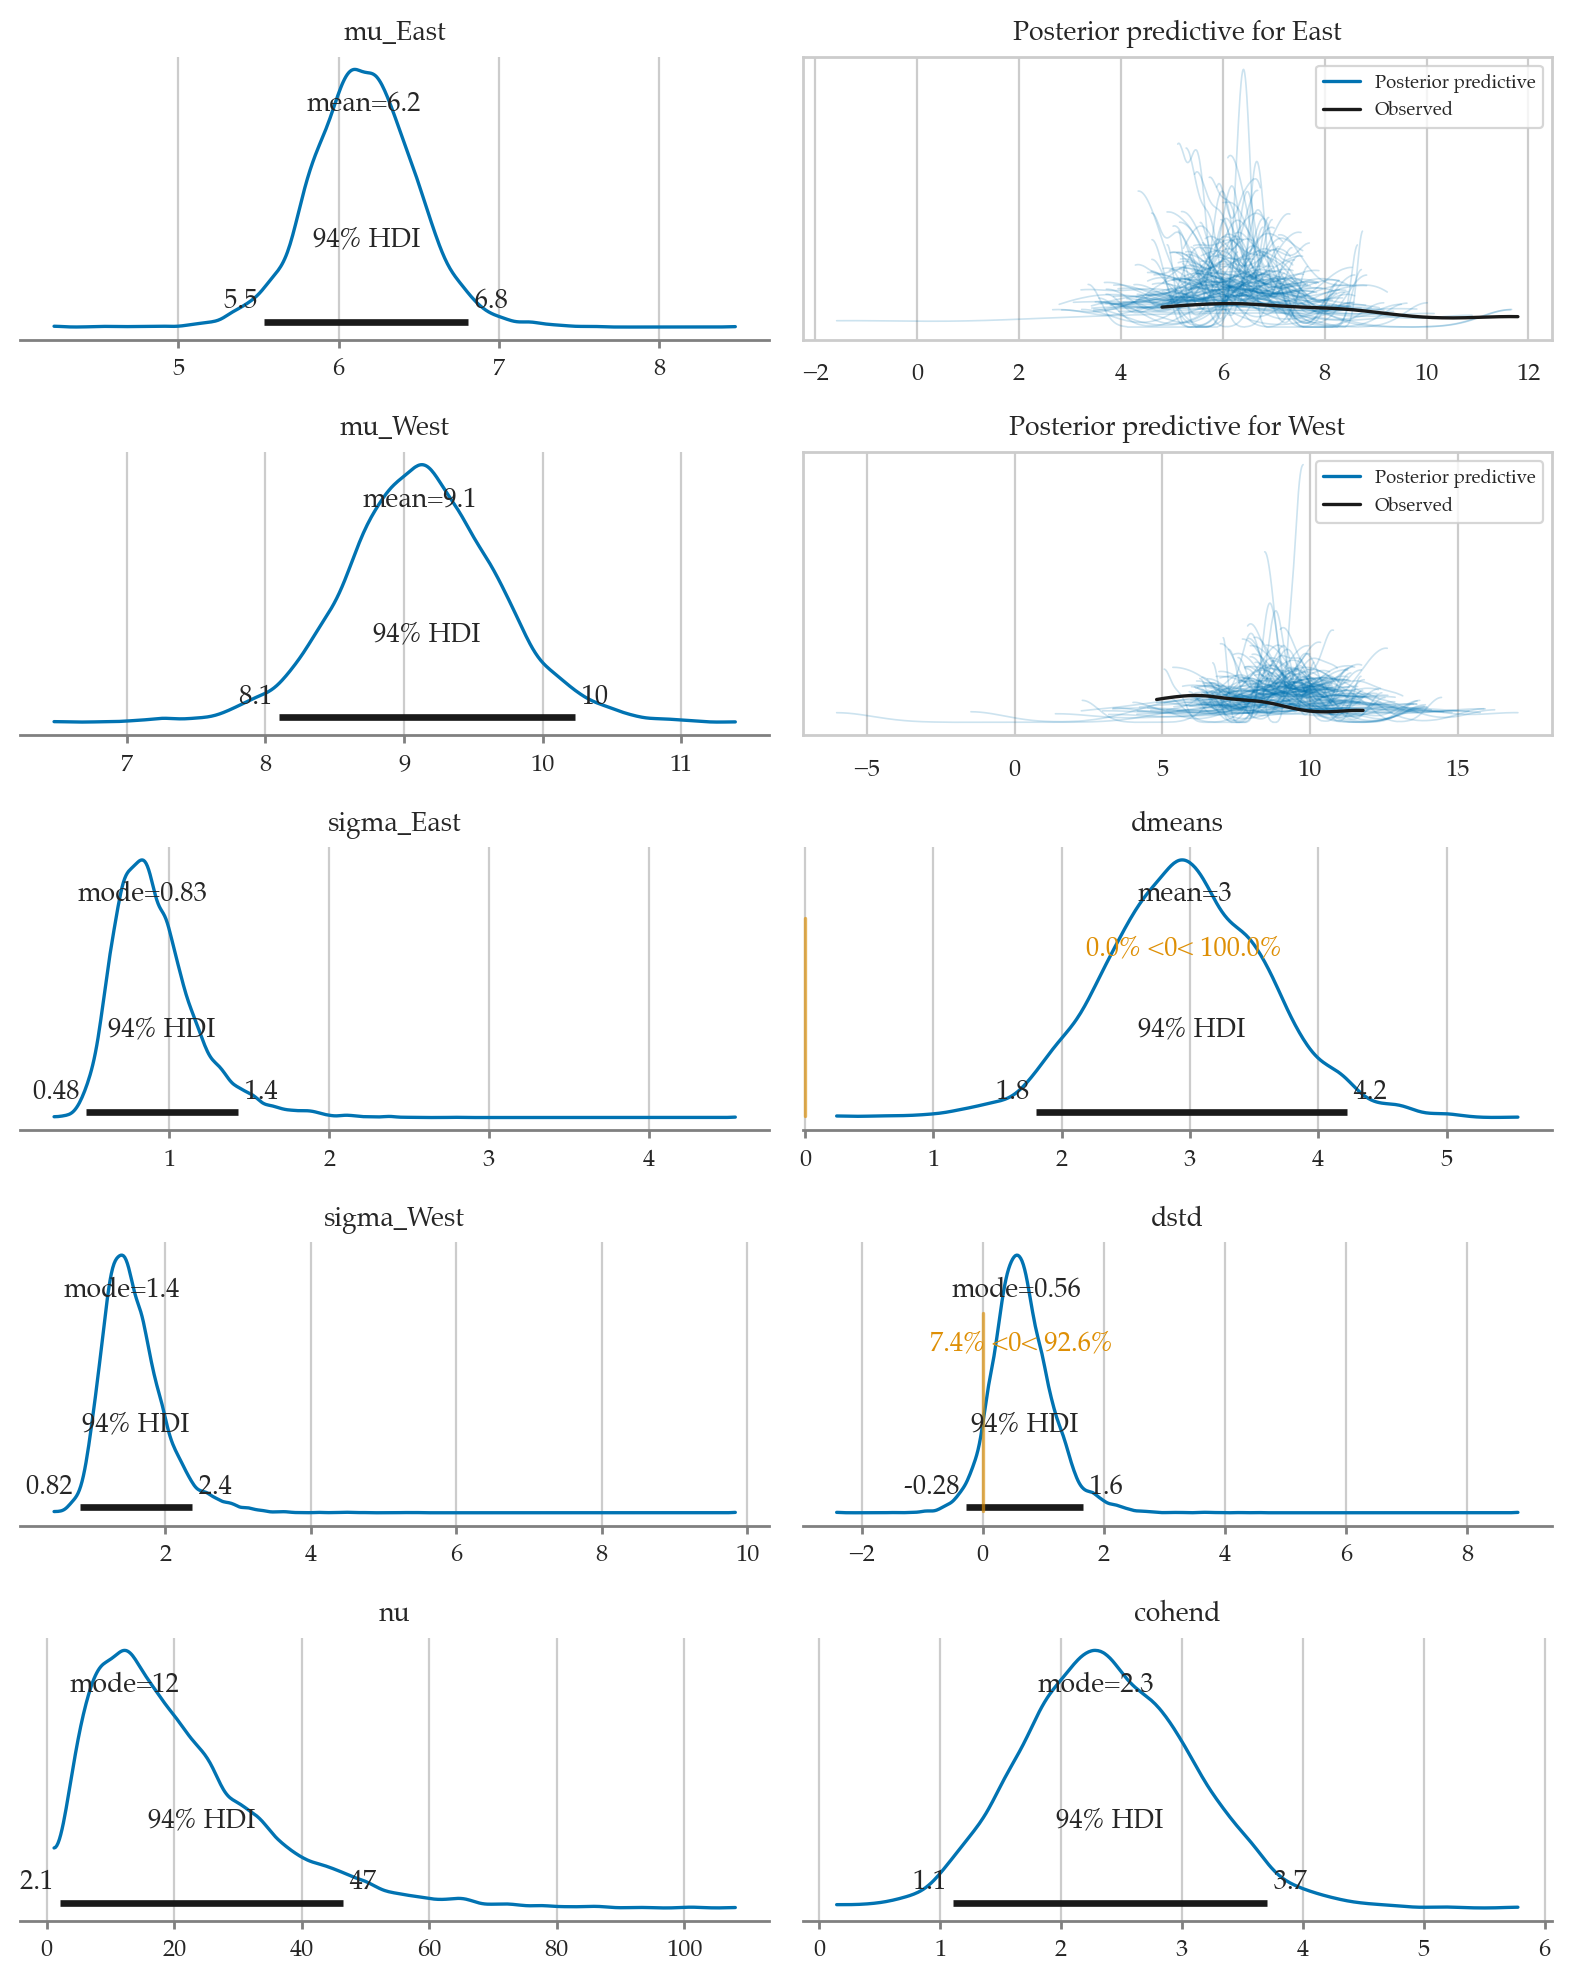

In [7]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod1, idata1, group_name="loc");

## Example 2: comparing IQ scores

We'll look at IQ scores data taken from a the paper *Bayesian Estimation Supersedes the t-Test* (BEST) by John K. Kruschke.

### Data

In [27]:
iqs2 = pd.read_csv("../datasets/iqs2.csv")
iqs2.groupby("group")["iq"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctrl,42.0,100.357143,2.516496,88.0,100.0,100.5,101.0,105.0
treat,47.0,101.914894,6.021085,82.0,100.0,102.0,103.0,124.0


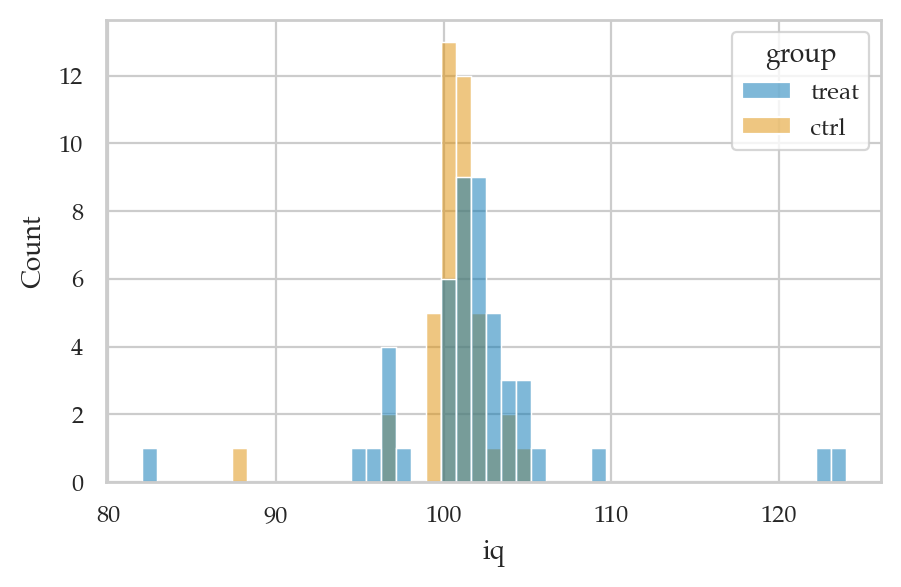

In [9]:
sns.histplot(data=iqs2, x="iq", hue="group");

### Model

In [10]:
formula2 = bmb.Formula("iq ~ 1 + group",
                       "sigma ~ 0 + group")

mod2 = bmb.Model(formula=formula2,
                 family="t",
                 link="identity",
                 data=iqs2)
mod2

       Formula: iq ~ 1 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)

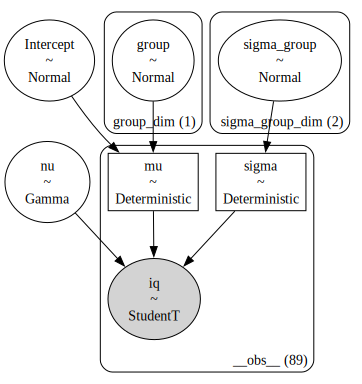

In [11]:
mod2.build()
mod2.graph()

In [12]:
idata2 = mod2.fit(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


In [13]:
# ALT. manual calculations
# post2 = idata2["posterior"]
# # Calculate sigmas from log-sigmas
# post2["sigma_treat"] = np.exp(post2["sigma_group"][:,:,1])
# post2["sigma_ctrl"] = np.exp(post2["sigma_group"][:,:,0])
# # Difference in standard deviations
# post2["dstd"] = post2["sigma_treat"] - post2["sigma_ctrl"]

In [14]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata2, group_name="group");
az.summary(idata2, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_treat", "sigma_ctrl", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,1.028,0.418,0.207,1.853
sigma_treat,1.937,0.408,1.190,2.752
sigma_ctrl,1.014,0.199,0.643,1.404
dstd,0.923,0.416,0.150,1.772
nu,1.809,0.469,0.998,2.732
cohend,0.685,0.303,0.093,1.277


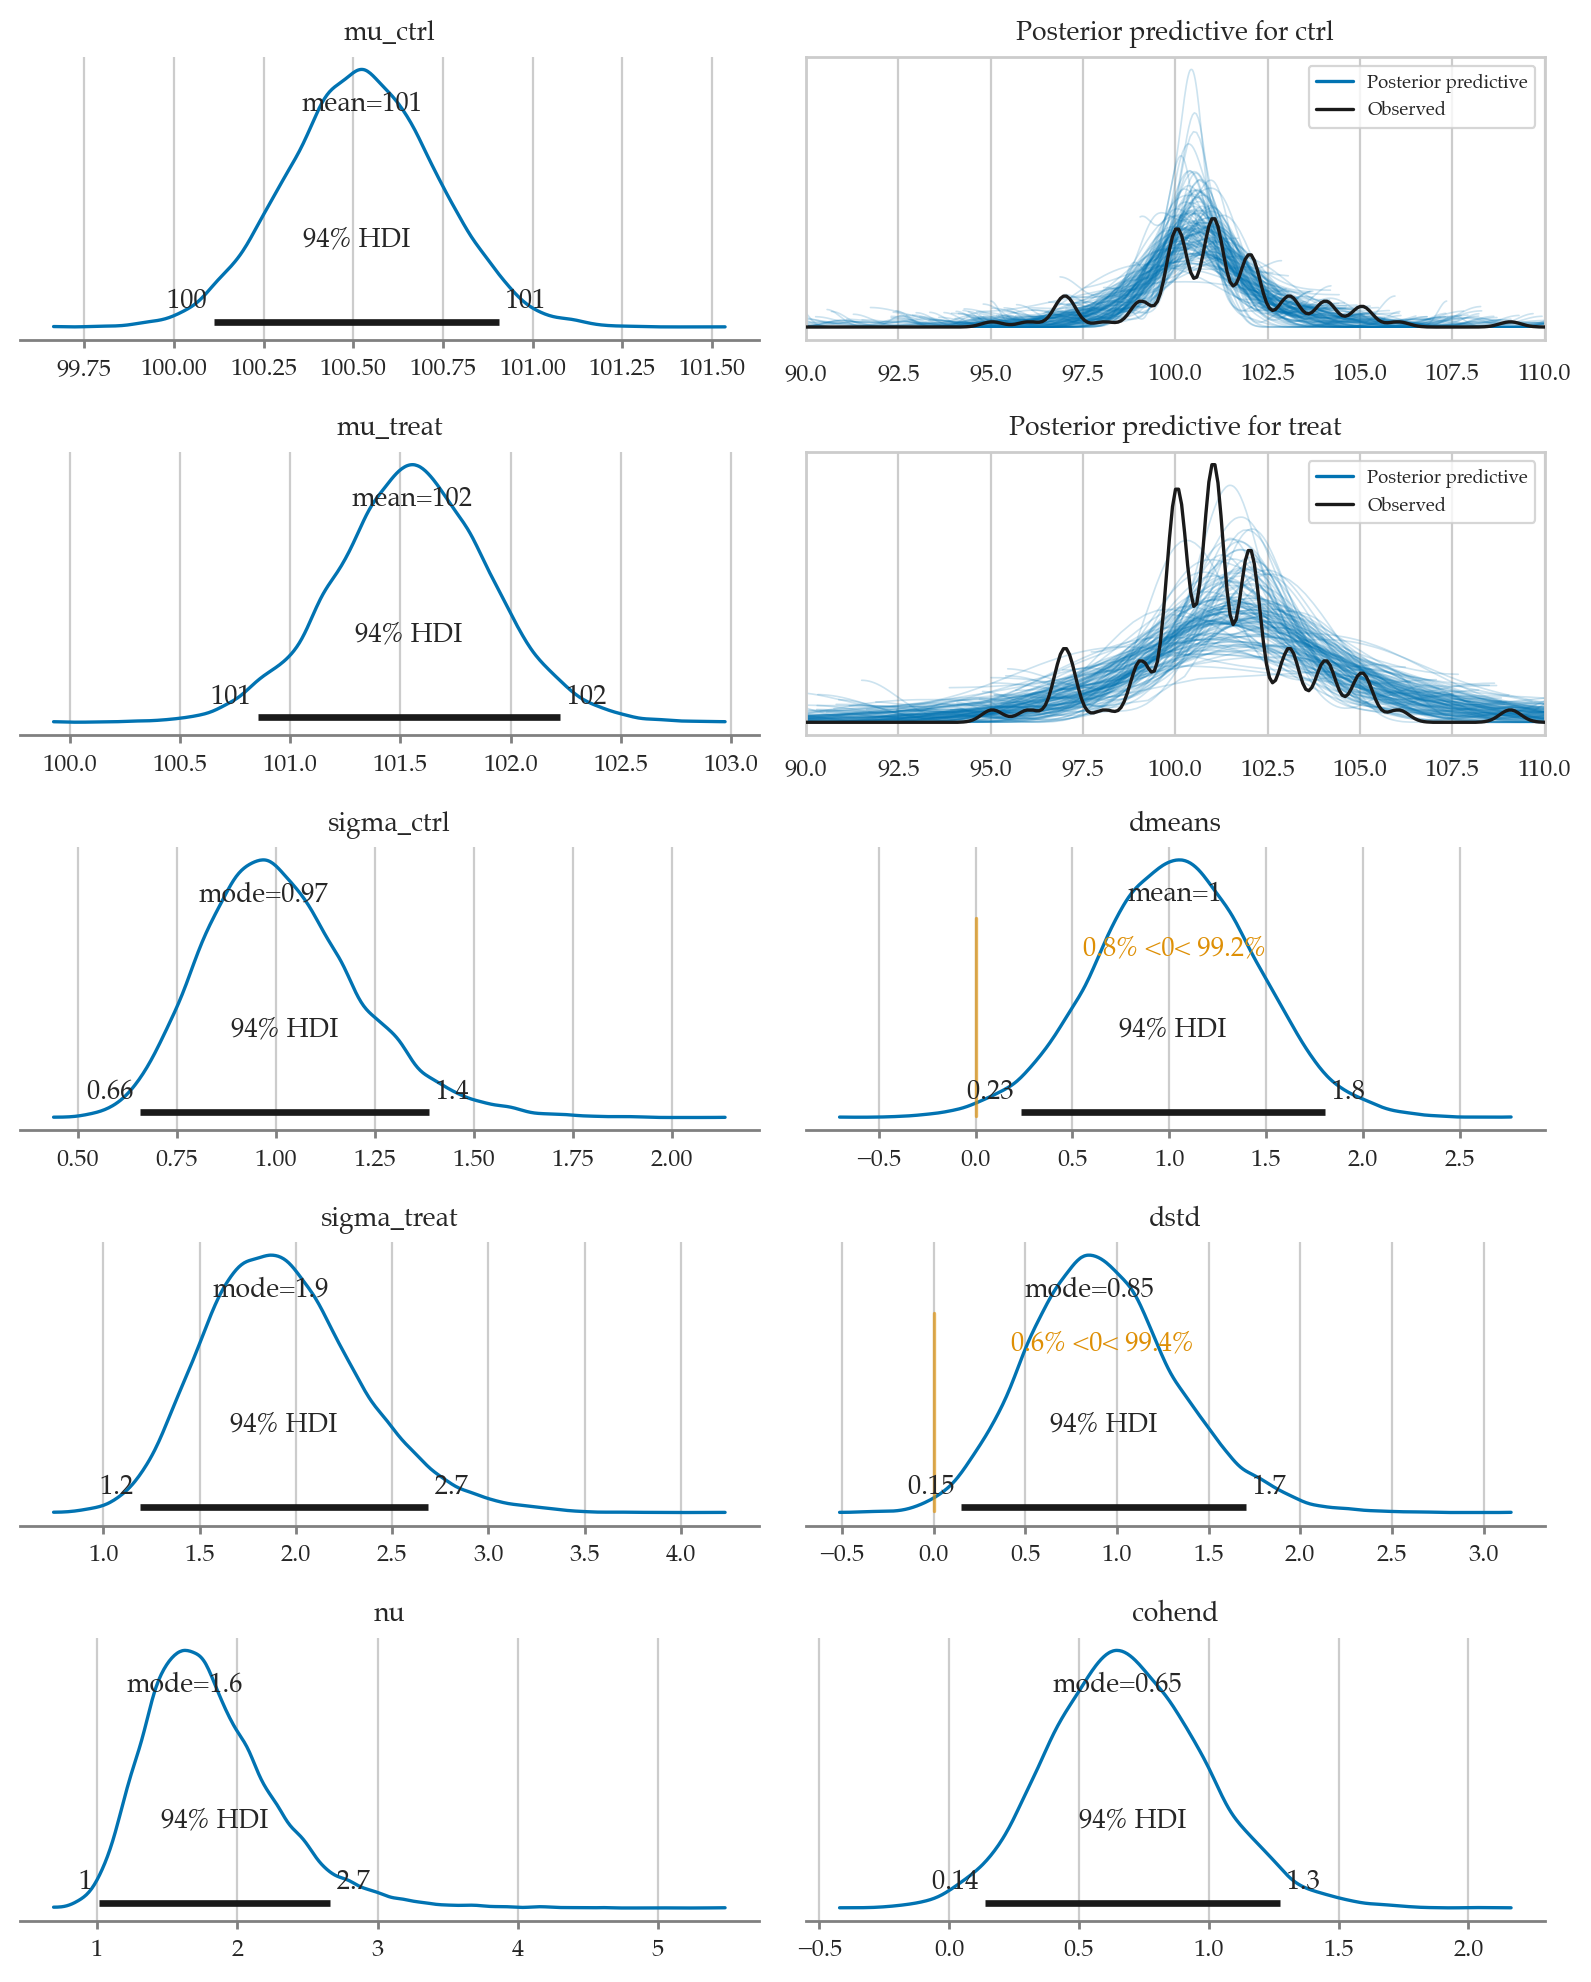

In [15]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod2, idata2, group_name="group", ppc_xlims=[90,110]);

## Example 3: lecture and debate curriculums


### Data

In [25]:
students = pd.read_csv("../datasets/students.csv")
students.groupby("curriculum")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
curriculum,,,,,,,,
debate,8.0,76.462500,10.519633,62.9,69.55,75.55,80.925,96.2
lecture,7.0,68.142857,7.758406,57.0,63.30,70.30,73.850,75.4


In [33]:
from ministats.bayes import bayes_dmeans

studentsD = students[students["curriculum"]=="debate"]
studentsL = students[students["curriculum"]=="lecture"]
scoresD = studentsD["score"]
scoresL = studentsL["score"]

mod3, idata3 = bayes_dmeans(scoresD, scoresL, group_name="curriculum", var_name="score", groups=["debate", "lecture"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, curriculum, sigma_curriculum]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [35]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata3, group_name="curriculum");
az.summary(idata3, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_debate", "sigma_lecture", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-7.086,4.804,-16.269,2.364
sigma_debate,8.782,2.746,3.803,14.663
sigma_lecture,6.672,2.278,2.335,11.251
dstd,-2.110,3.302,-8.707,4.496
nu,17.108,13.624,0.621,43.963
cohend,-0.924,0.621,-2.113,0.312


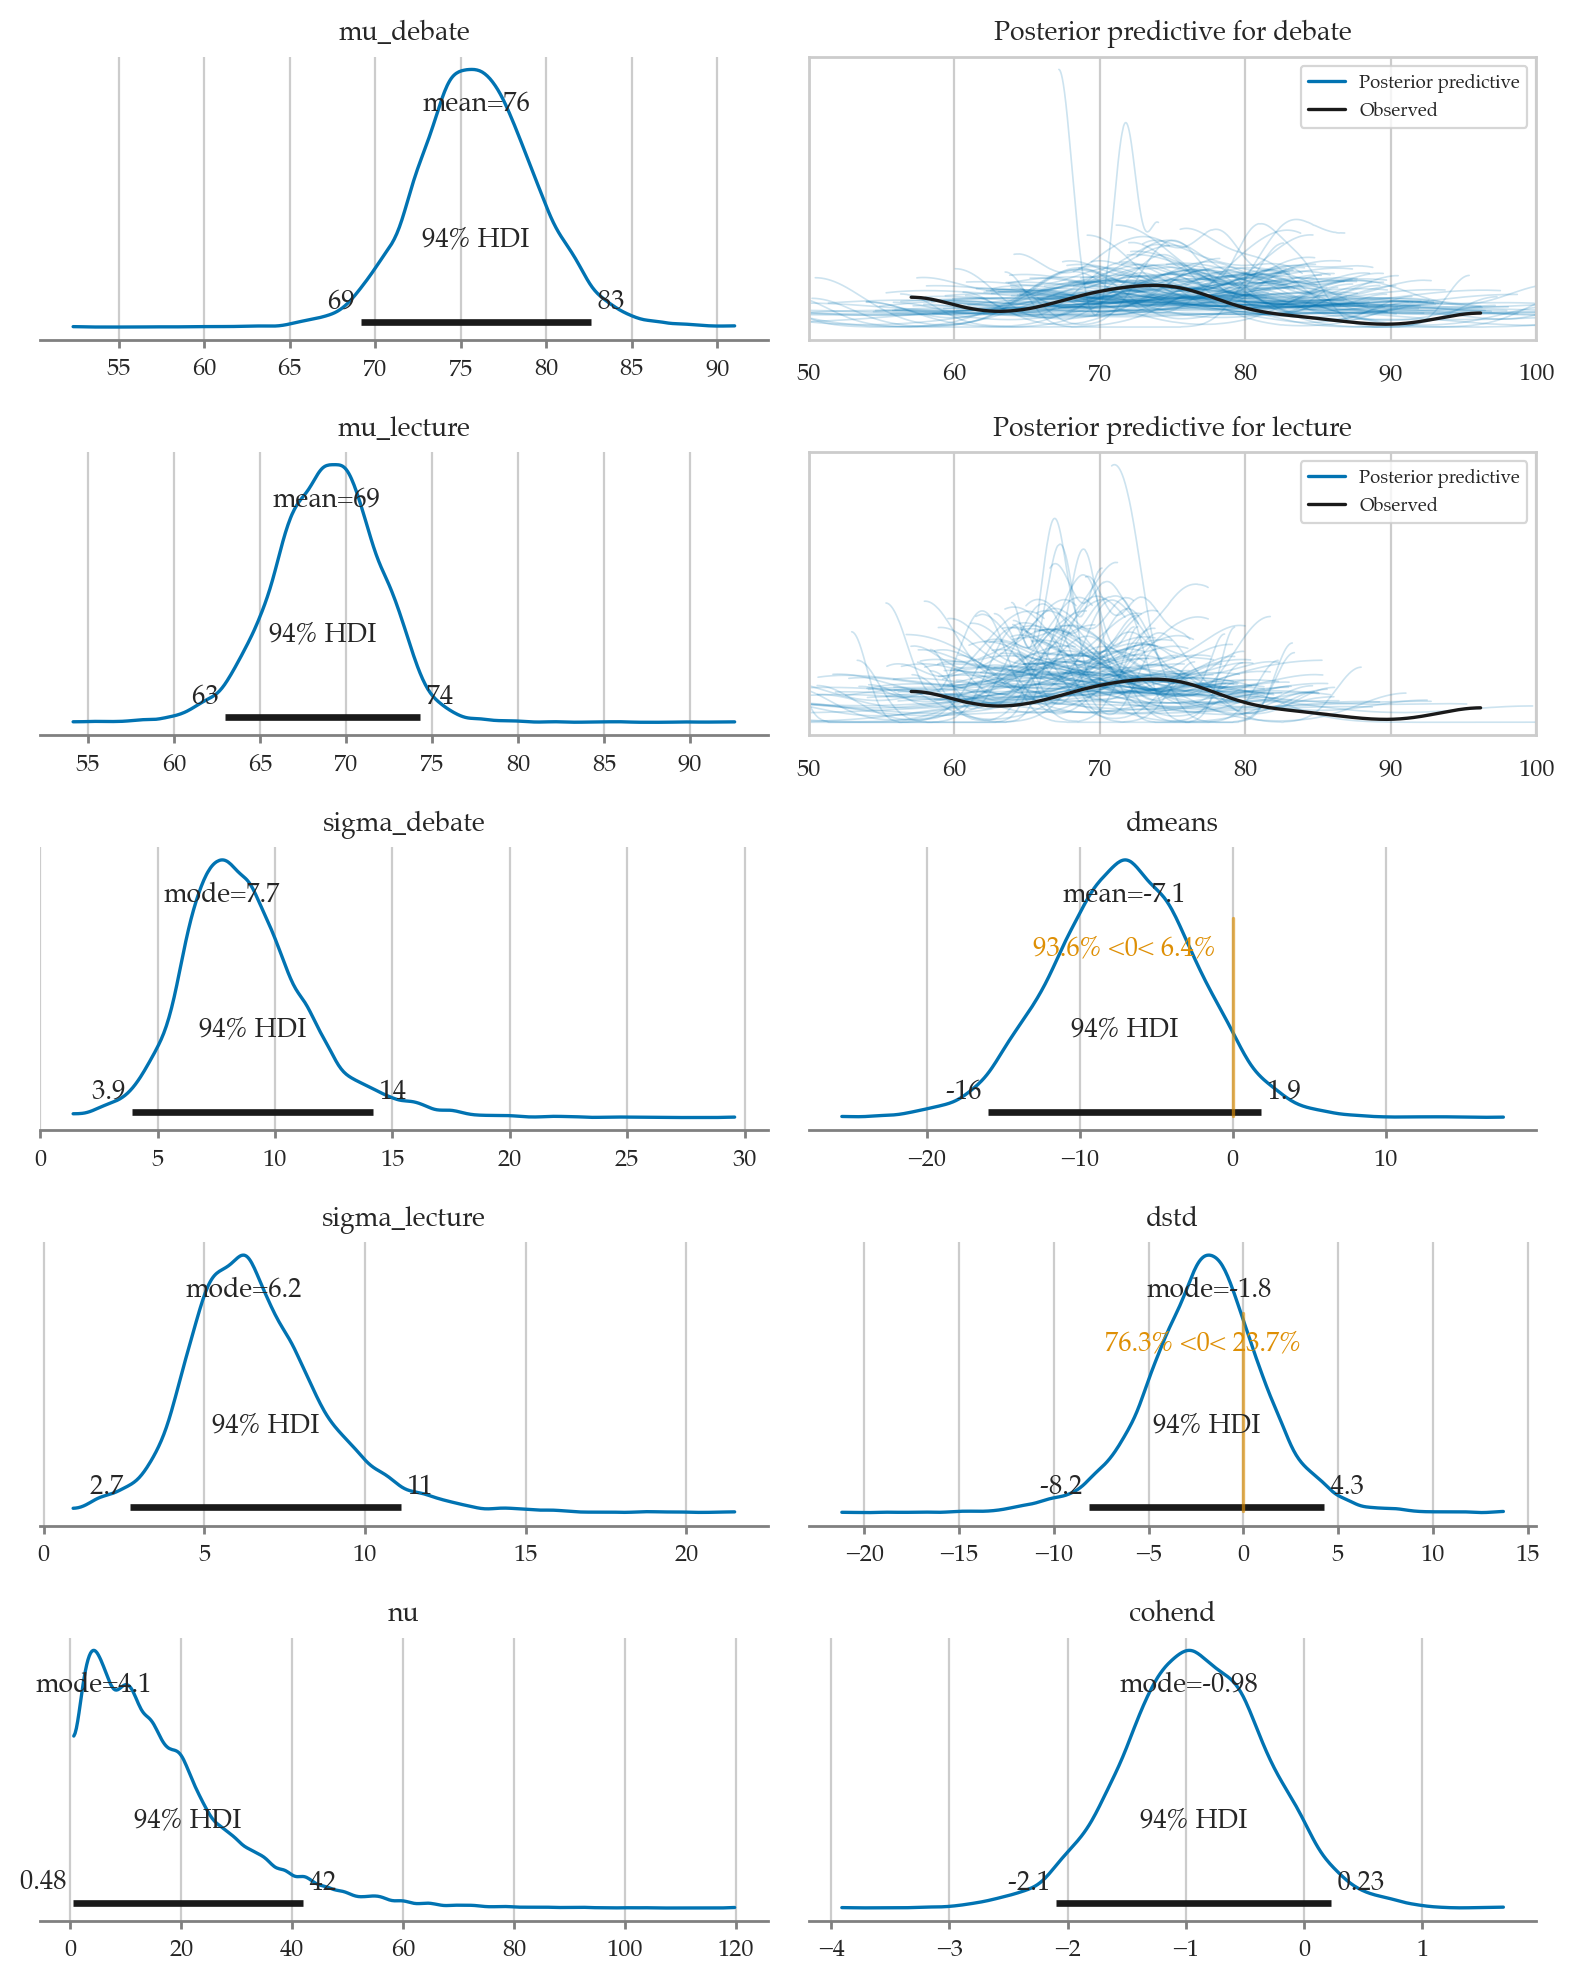

In [39]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod3, idata3, group_name="curriculum", ppc_xlims=[50,100]);

## Example 4: small example form BEST vignette

See http://cran.nexr.com/web/packages/BEST/vignettes/BEST.pdf#page=2


In [41]:
y1s = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
y2s = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]

from ministats.bayes import bayes_dmeans
mod4, idata4 = bayes_dmeans(y1s, y2s, groups=["y1", "y2"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [42]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata4)
az.summary(idata4, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_y1", "sigma_y2", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-1.443,0.494,-2.398,-0.462
sigma_y1,0.852,0.330,0.366,1.487
sigma_y2,0.718,0.285,0.310,1.272
dstd,-0.135,0.431,-0.988,0.733
nu,21.441,14.194,1.805,49.385
cohend,-1.922,0.784,-3.437,-0.386


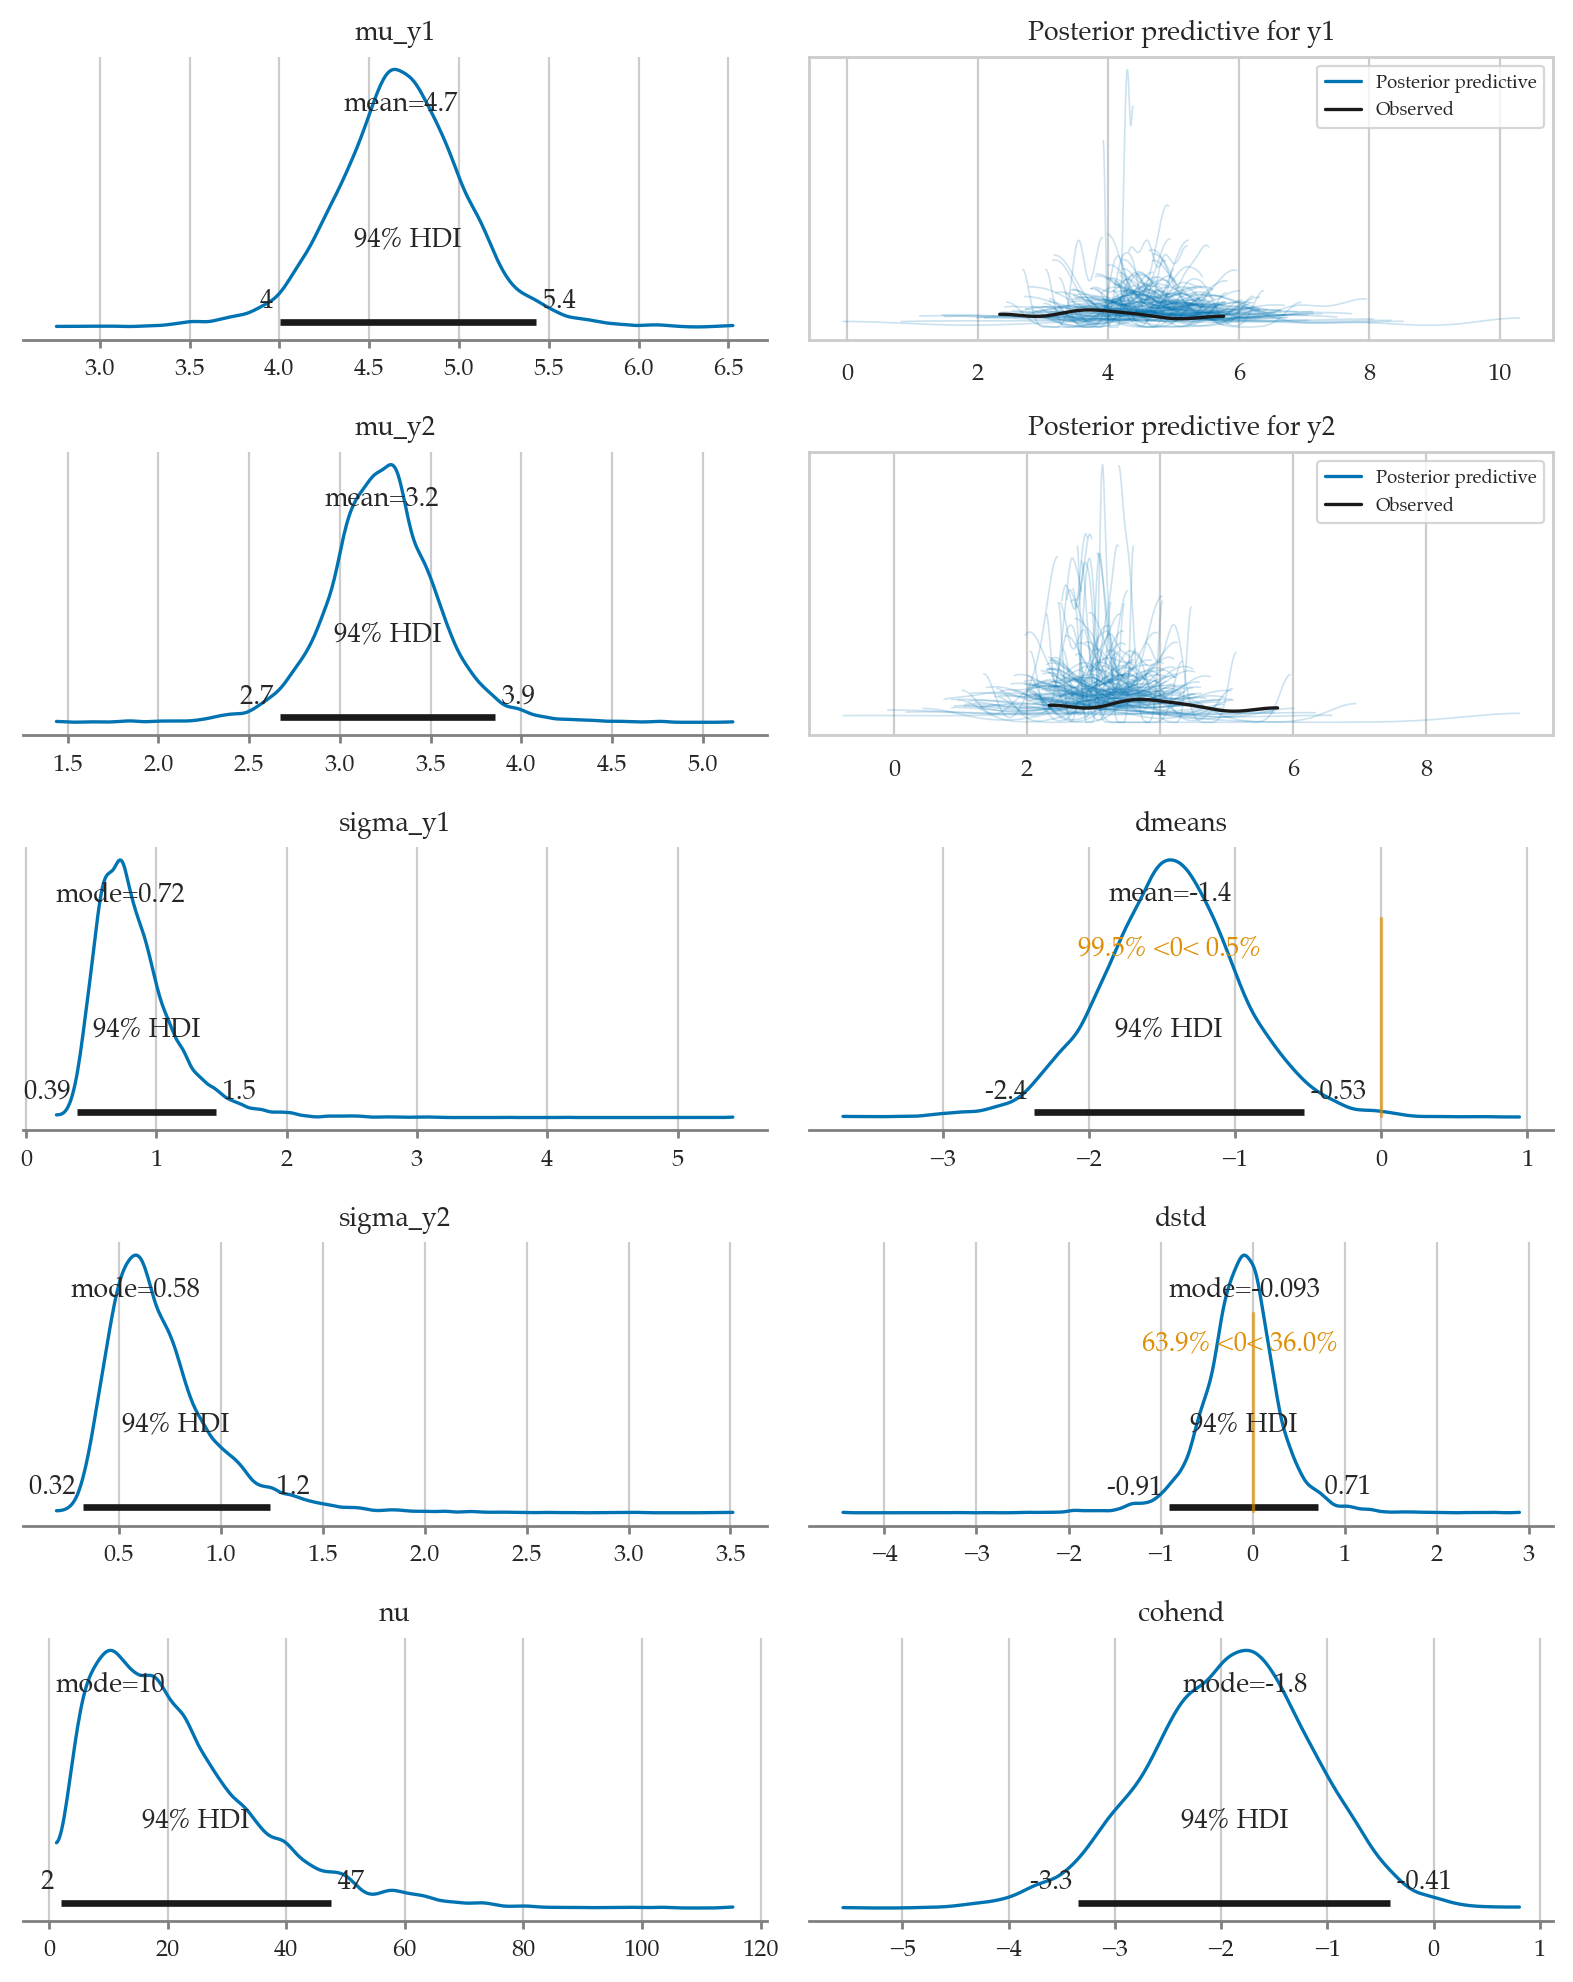

In [43]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod4, idata4, ppc_xlims=None);

## Example 5: comparing morning to evening

https://github.com/treszkai/best/blob/master/examples/paired_samples.py


In [46]:
morning = [8.99, 9.21, 9.03, 9.15, 8.68, 8.82, 8.66, 8.82, 8.59, 8.14,
           9.09, 8.80, 8.18, 9.23, 8.55, 9.03, 9.36, 9.06, 9.57, 8.38]
evening = [9.82, 9.34, 9.73, 9.93, 9.33, 9.41, 9.48, 9.14, 8.62, 8.60,
           9.60, 9.41, 8.43, 9.77, 8.96, 9.81, 9.75, 9.50, 9.90, 9.13]

In [50]:
from ministats.bayes import bayes_dmeans
mod5, idata5 = bayes_dmeans(evening, morning, groups=["evening", "morning"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [51]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata5)
az.summary(idata5, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_evening", "sigma_morning", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-0.529,0.142,-0.804,-0.254
sigma_evening,0.456,0.085,0.308,0.631
sigma_morning,0.388,0.072,0.263,0.532
dstd,-0.068,0.109,-0.292,0.142
nu,22.751,13.852,2.754,49.829
cohend,-1.266,0.378,-1.992,-0.509


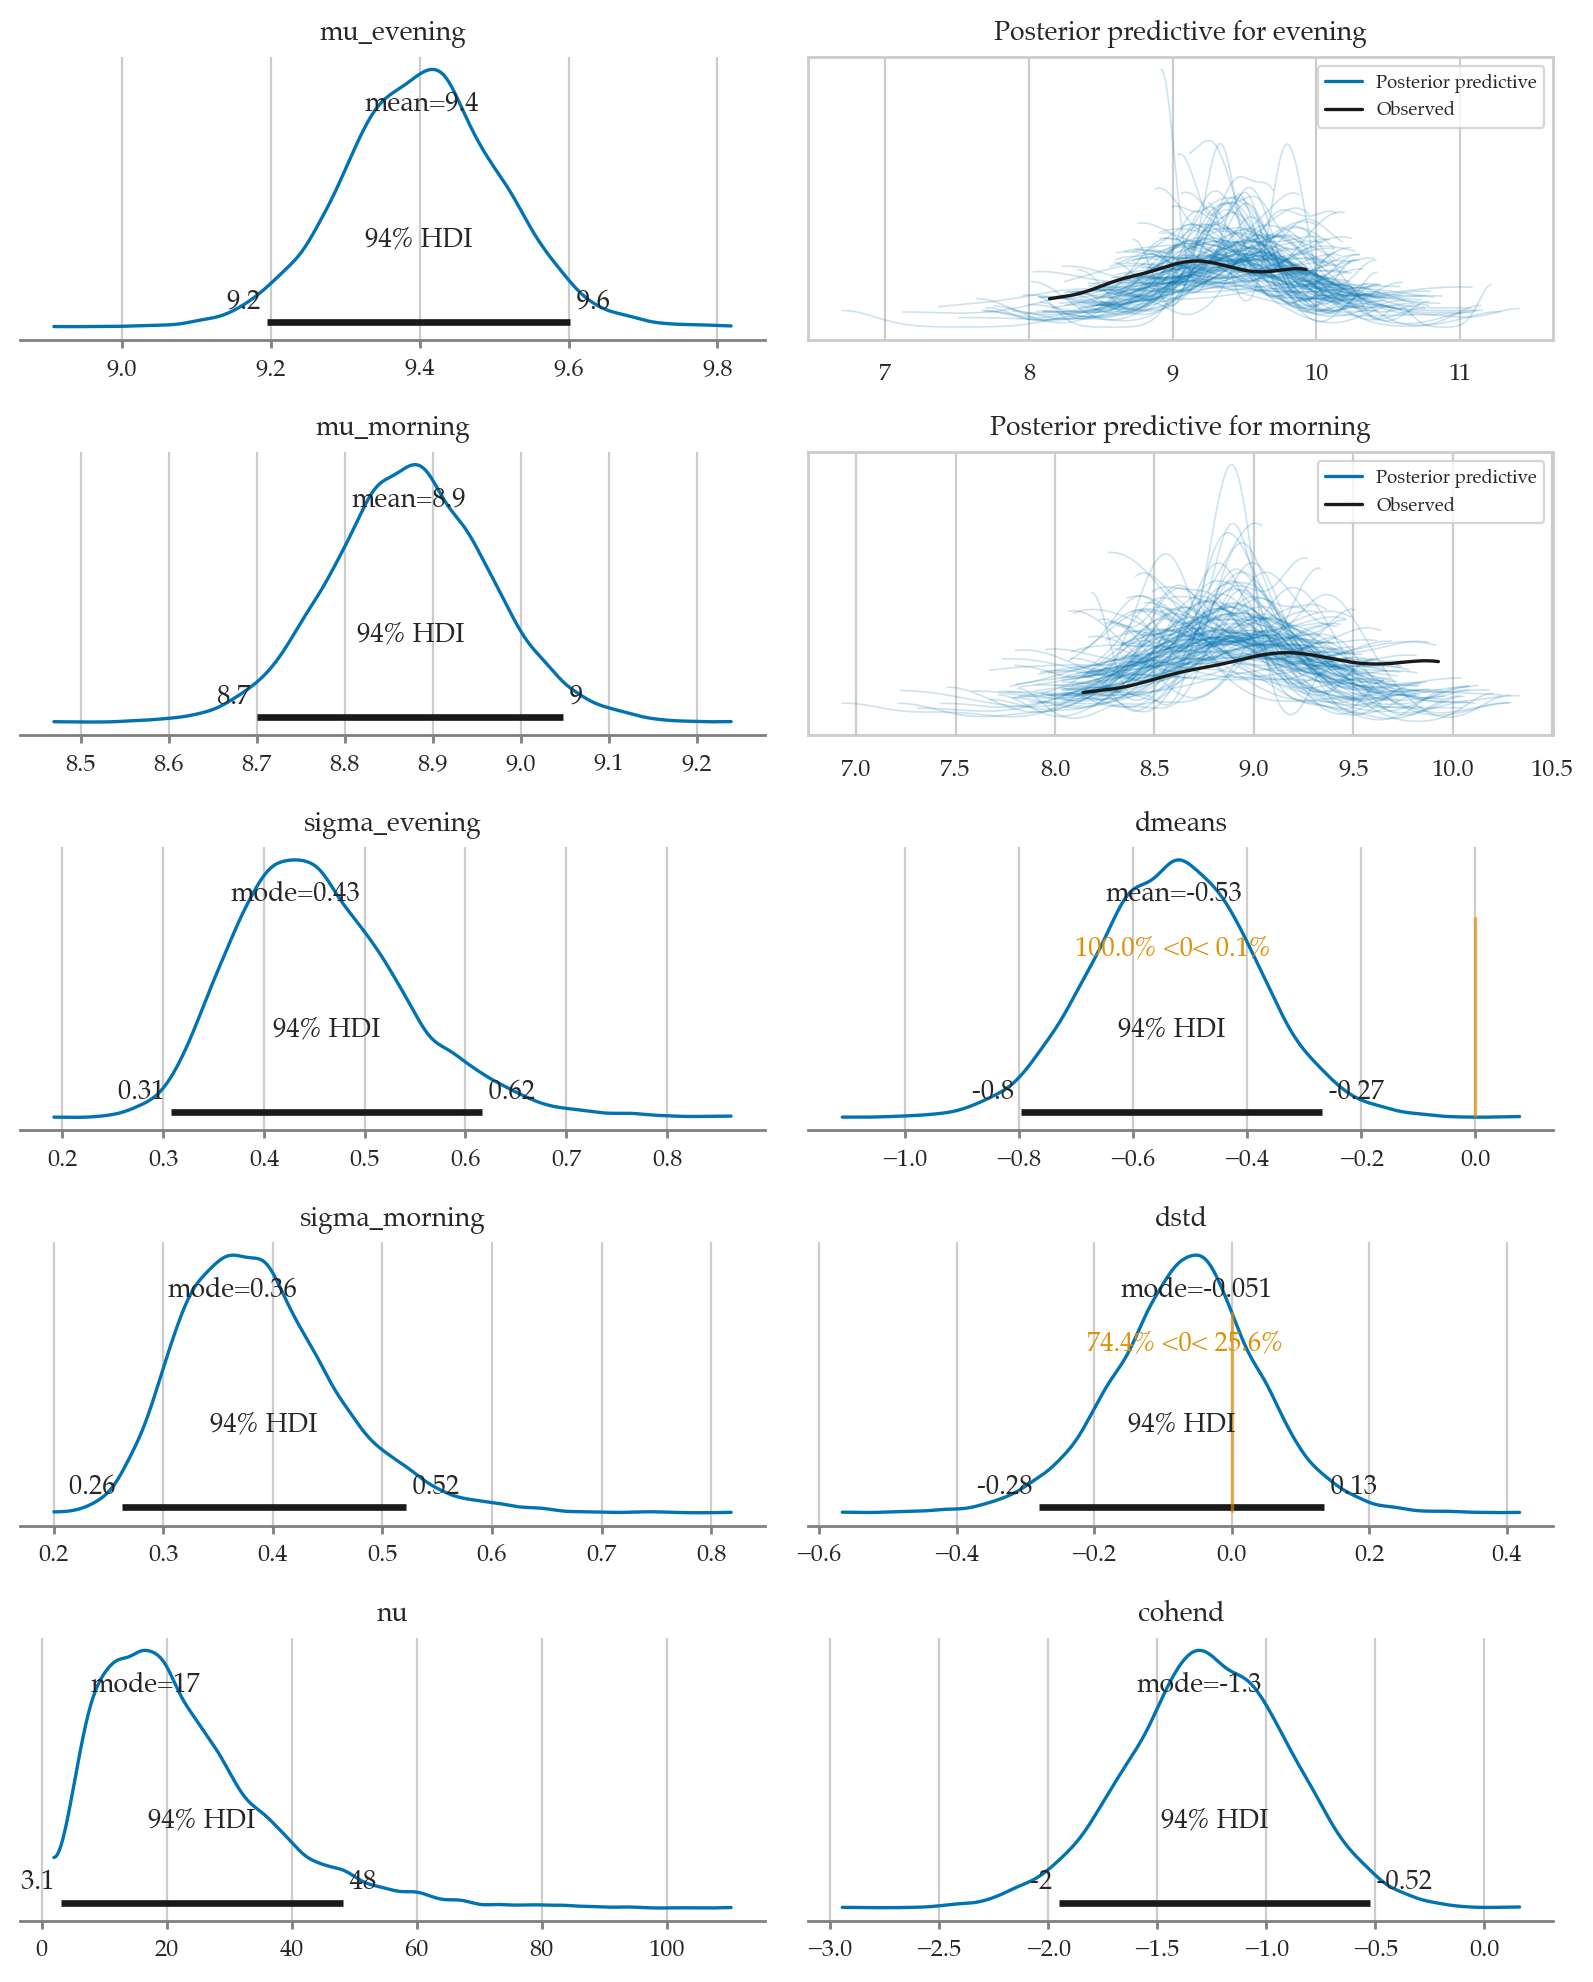

In [52]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod5, idata5, ppc_xlims=None);

## Exercises

### Exercise 1: small samples

In [16]:
As = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
Bs = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]
groups = ["A"]*len(As) + ["B"]*len(Bs)
df1 = pd.DataFrame({"group": groups, "vals": As + Bs})
# df1

In [17]:
from scipy.stats import t as tdist

tdist(loc=100, scale=10, df=2.1).std()

45.82575694955838

In [18]:
10 * np.sqrt(2.1 / (2.1-2))

45.82575694955838

alpha=1.0 beta=0.03333333333333333


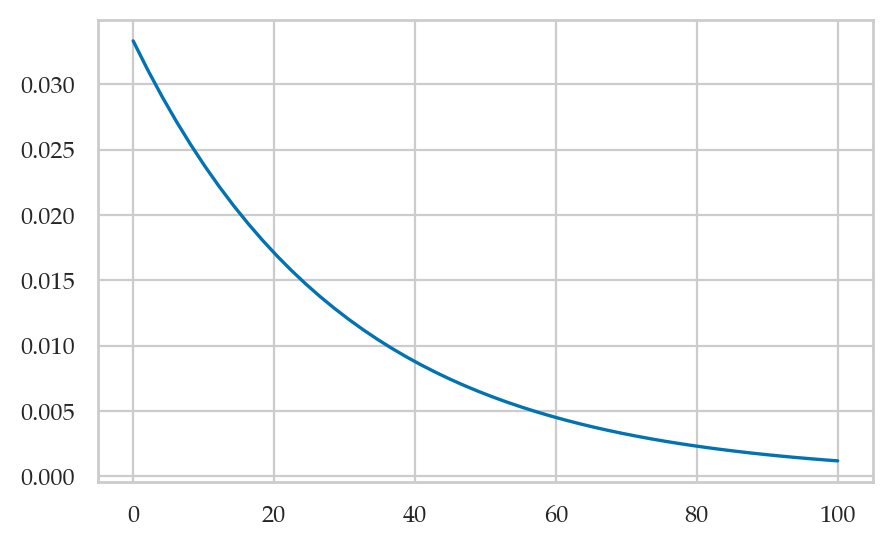

In [19]:
# New Default prior in R BEST code
from scipy.stats import gamma

nuMean = 30
nuSD = 30

alpha = nuMean**2 / nuSD**2  # shape
beta = nuMean / nuSD**2   # rate
print(f"{alpha=} {beta=}")

rv_Nu = gamma(a=alpha, scale=1/beta)
xs = np.linspace(0,100)
ax = sns.lineplot(x=xs, y=rv_Nu.pdf(xs));

<Axes: >

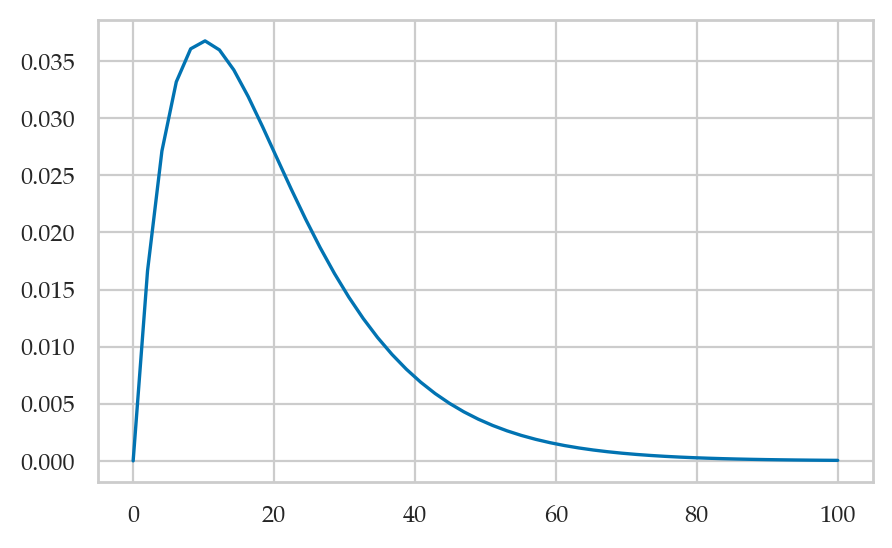

In [20]:
# Bambi default prior for `nu`
rv_Nu2 = gamma(a=2, scale=10)
xs = np.linspace(0,100)
sns.lineplot(x=xs, y=rv_Nu2.pdf(xs))

In [21]:
from ministats.bayes import bayes_dmeans

treated = iqs2[iqs2["group"]=="treat"]["iq"].values
controls = iqs2[iqs2["group"]=="ctrl"]["iq"].values

model, idata = bayes_dmeans(treated, controls, var_name="iq",
                            group_name="group", groups=["treat", "ctrl"])
model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


       Formula: iq ~ 1 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [22]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,100.526,0.212,100.130,100.921,0.002,0.001,13056.0,6476.0,1.0
group[treat],1.027,0.418,0.249,1.832,0.005,0.004,6295.0,5618.0,1.0
nu,1.805,0.446,1.065,2.652,0.006,0.004,5314.0,5838.0,1.0
sigma_group[ctrl],-0.004,0.193,-0.360,0.362,0.002,0.002,6584.0,6335.0,1.0
sigma_group[treat],0.639,0.205,0.261,1.033,0.003,0.002,5612.0,5373.0,1.0


In [23]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata, group_name="group")
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,100.526,0.212,100.130,100.921,0.002,0.001,13056.0,6476.0,1.0
group[treat],1.027,0.418,0.249,1.832,0.005,0.004,6295.0,5618.0,1.0
nu,1.805,0.446,1.065,2.652,0.006,0.004,5314.0,5838.0,1.0
sigma_group[ctrl],-0.004,0.193,-0.360,0.362,0.002,0.002,6584.0,6335.0,1.0
sigma_group[treat],0.639,0.205,0.261,1.033,0.003,0.002,5612.0,5373.0,1.0
dmeans,1.027,0.418,0.249,1.832,0.005,0.004,6295.0,5618.0,1.0
mu_ctrl,100.526,0.212,100.130,100.921,0.002,0.001,13056.0,6476.0,1.0
mu_treat,101.553,0.357,100.851,102.210,0.005,0.003,5220.0,4774.0,1.0
sigma_ctrl,1.014,0.197,0.667,1.382,0.002,0.002,6584.0,6335.0,1.0
sigma_treat,1.935,0.397,1.208,2.669,0.005,0.004,5612.0,5373.0,1.0


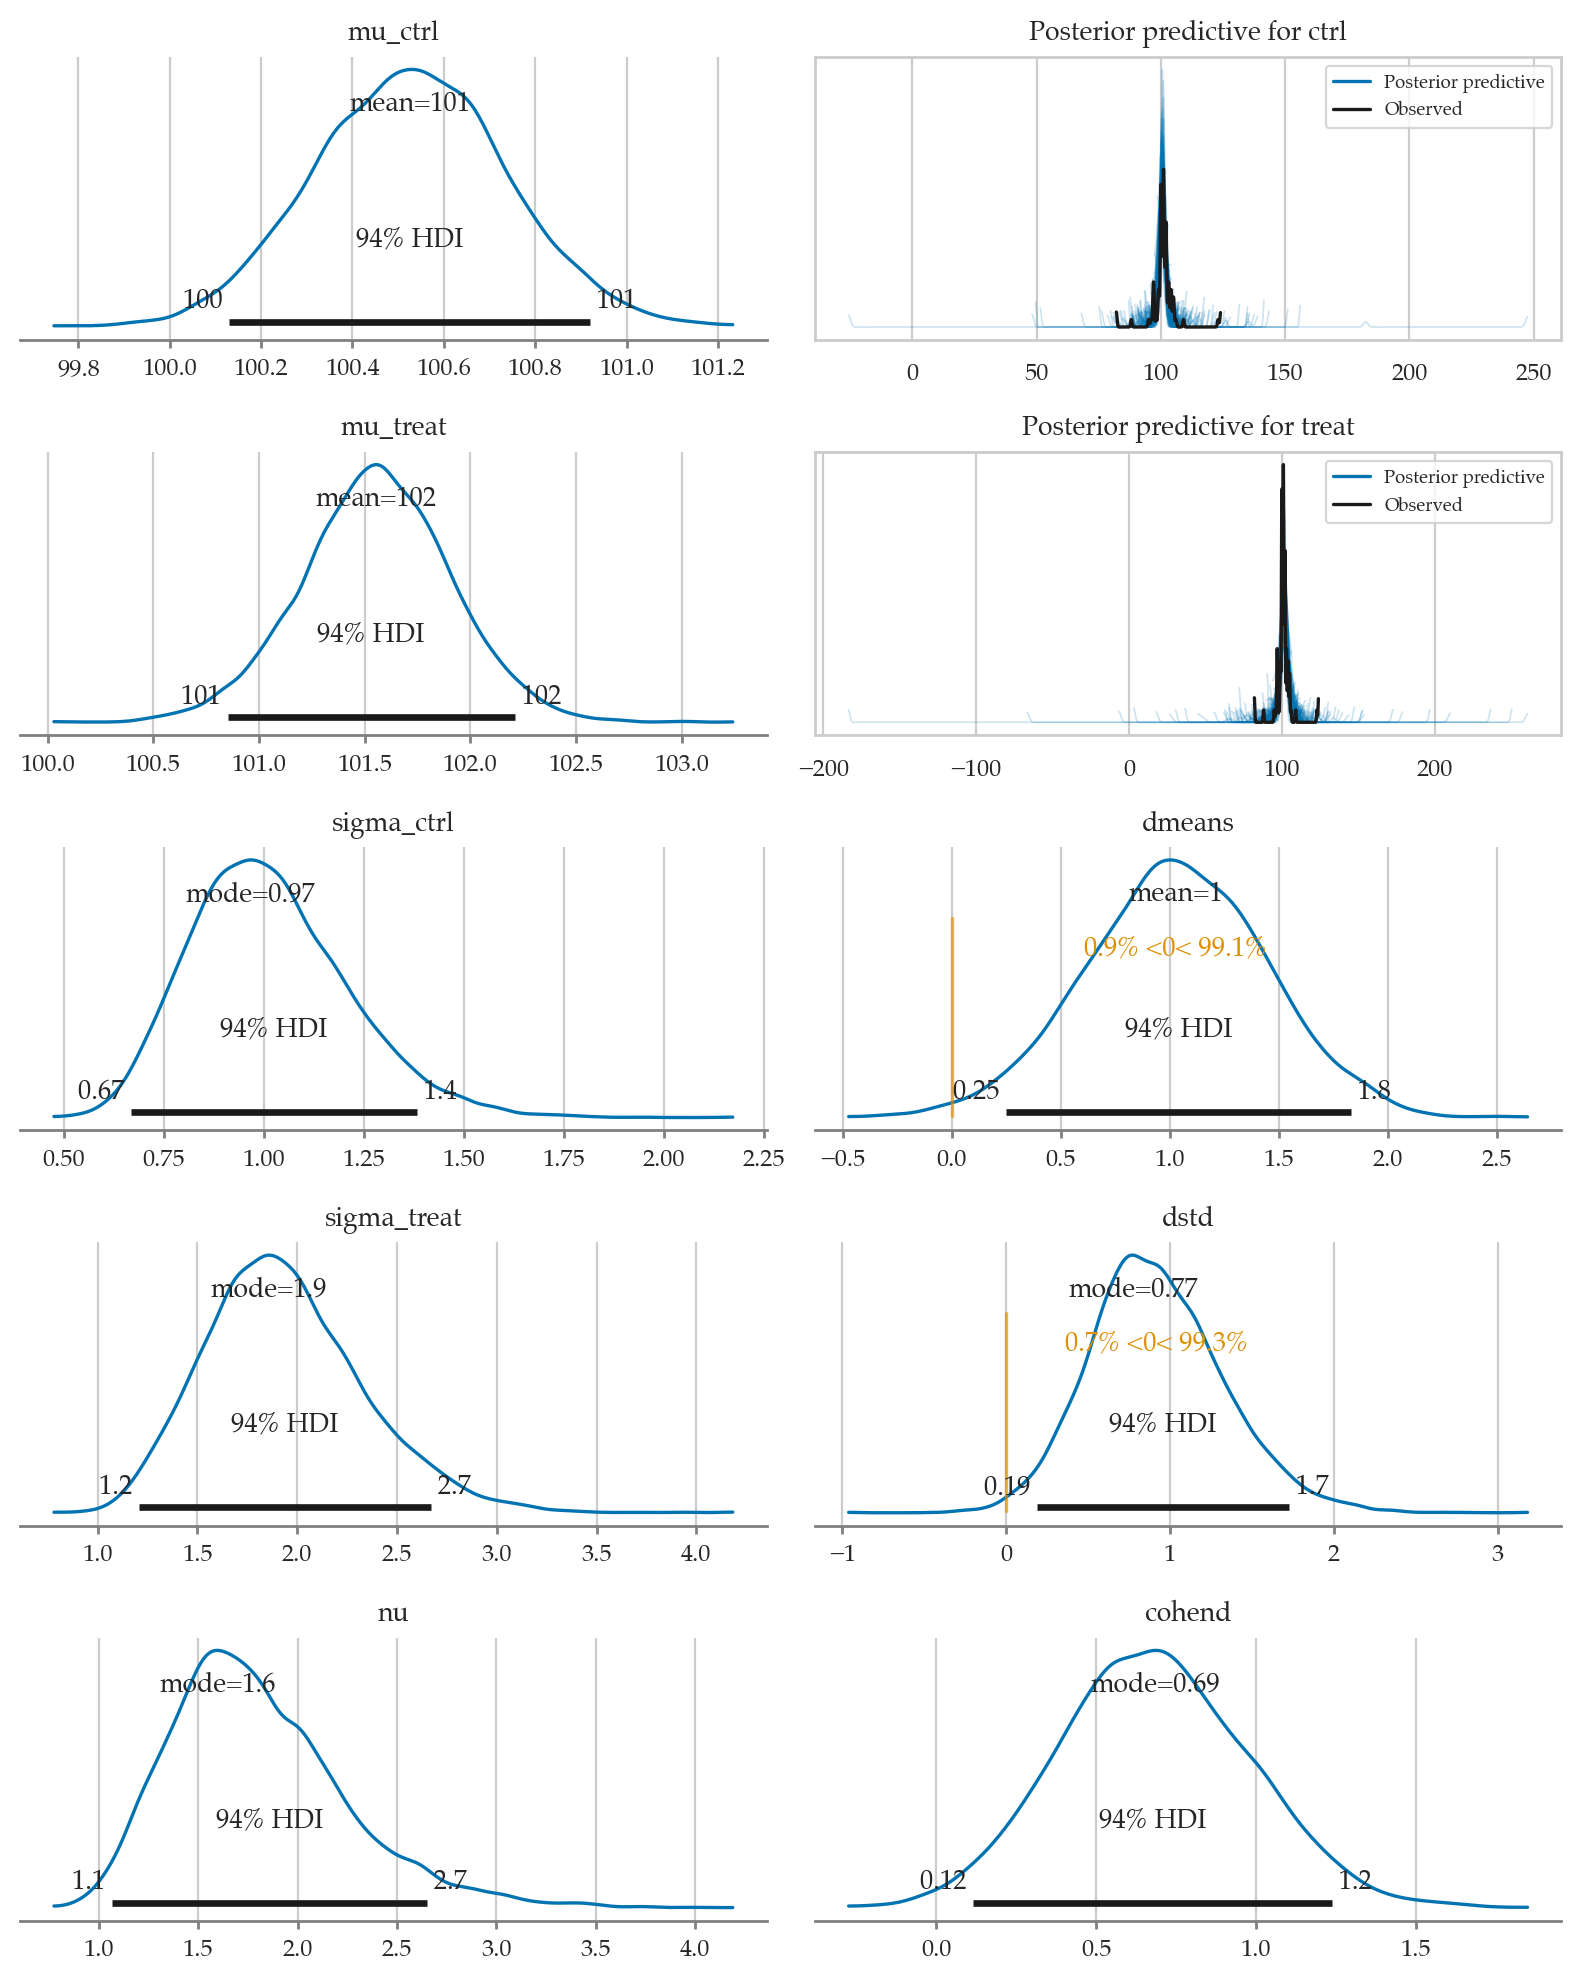

In [24]:
# az.plot_posterior(idata);

from ministats.bayes import plot_dmeans_stats

plot_dmeans_stats(model, idata, group_name="group");